In [3]:
#imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import time as systime
import datetime as dtime
import string
import seaborn as sns
from sklearn.ensemble import RandomForestClassifier #this is a classification problem
from sklearn.cross_validation import train_test_split #for splitting the training set
from sklearn.metrics import log_loss #evaluation metric

%pylab inline

from IPython.core.display import HTML
def css_styling():
    styles = open("style.css", "r").read()
    return HTML(styles)
css_styling()

Populating the interactive namespace from numpy and matplotlib


/Library/Python/2.7/site-packages/IPython/html.py:14: ShimWarning: The `IPython.html` package has been deprecated. You should import from `notebook` instead. `IPython.html.widgets` has moved to `ipywidgets`.
  "`IPython.html.widgets` has moved to `ipywidgets`.", ShimWarning)


In [15]:
# functions
def splitDatetime(data): #function for splitting the timestamp
    sub = pd.DataFrame(data.Dates.str.split(' ').tolist(), columns = "date time".split())
    date = pd.DataFrame(sub.date.str.split('-').tolist(), columns="year month day".split())
    time = pd.DataFrame(sub.time.str.split(':').tolist(), columns = "hour minute second".split())
    data['year'] = date['year'].astype(int)
    data['month'] = date['month'].astype(int)
    data['day'] = date['day'].astype(int)
    data['hour'] = time['hour'].astype(int)
    # translating into weekday is not needed because that information is already in the data
    #data['weekday']=0 #weekday=0: monday, weekday=6: sunday.
    #for i in range(0,len(train.year)):
    #    data.weekday[i]=dtime.date(train.year[i], train.month[i], train.day[i]).weekday()   
    return data

def crossval(est, train, features, target): #cross-validation
    start = systime.time()    
    
    train, cv, target_train, target_cv = train_test_split(train[features], train[target], 
    test_size=0.33, # the size of the cross-validation set (~30% is good size)
    random_state=5) #random seed for splitting the data randomly

    est.fit(train, target_train)

    end = systime.time()
    LL = log_loss(target_cv.values.astype(pd.np.string_), est.predict_proba(np.array(cv[X])))
    
    print 'log-loss:', LL
    print 'elapsed time:', end-start

In [16]:
# read in the data

train = pd.read_csv('data/train.csv')
test = pd.read_csv('data/test.csv')
train = splitDatetime(train)
test = splitDatetime(test)

In [51]:
train.head(5)

,Dates,Category,Descript,DayOfWeek,PdDistrict,Resolution,Address,X,Y,year,month,day,hour,DOW,catnum,distnum
0,2015-05-13 23:53:00,WARRANTS,WARRANT ARREST,Wednesday,NORTHERN,"ARREST, BOOKED",OAK ST / LAGUNA ST,-122.425892,37.774599,2015,5,13,23,2,0,0
1,2015-05-13 23:53:00,OTHER OFFENSES,TRAFFIC VIOLATION ARREST,Wednesday,NORTHERN,"ARREST, BOOKED",OAK ST / LAGUNA ST,-122.425892,37.774599,2015,5,13,23,2,1,0
2,2015-05-13 23:33:00,OTHER OFFENSES,TRAFFIC VIOLATION ARREST,Wednesday,NORTHERN,"ARREST, BOOKED",VANNESS AV / GREENWICH ST,-122.424363,37.800414,2015,5,13,23,2,1,0
3,2015-05-13 23:30:00,LARCENY/THEFT,GRAND THEFT FROM LOCKED AUTO,Wednesday,NORTHERN,NONE,1500 Block of LOMBARD ST,-122.426995,37.800873,2015,5,13,23,2,2,0
4,2015-05-13 23:30:00,LARCENY/THEFT,GRAND THEFT FROM LOCKED AUTO,Wednesday,PARK,NONE,100 Block of BRODERICK ST,-122.438738,37.771541,2015,5,13,23,2,2,1


In [150]:
# find out if there are any missing values
# luckily there are no missing values (the data is clean)

print train.isnull().sum()

Dates         0
Category      0
Descript      0
DayOfWeek     0
PdDistrict    0
Resolution    0
Address       0
X             0
Y             0
year          0
month         0
day           0
hour          0
DOW           0
catnum        0
event         0
count         0
dtype: int64


In [17]:
# this is a map, mapping day of week to a number:
dow = {
    'Monday':0,
    'Tuesday':1,
    'Wednesday':2,
    'Thursday':3,
    'Friday':4,
    'Saturday':5,
    'Sunday':6
}

# this is the inverse map:
wod = {v: k for k, v in dow.items()}

# map for categories->numbers
catnum = {
'WARRANTS':0, 'OTHER OFFENSES':1, 'LARCENY/THEFT':2, 'VEHICLE THEFT':3, 'VANDALISM':4,
 'NON-CRIMINAL':5, 'ROBBERY':6, 'ASSAULT':7, 'WEAPON LAWS':8, 'BURGLARY':9,
 'SUSPICIOUS OCC':10, 'DRUNKENNESS':11, 'FORGERY/COUNTERFEITING':12, 'DRUG/NARCOTIC':13,
 'STOLEN PROPERTY':14, 'SECONDARY CODES':15, 'TRESPASS':16, 'MISSING PERSON':17, 'FRAUD':18,
 'KIDNAPPING':19, 'RUNAWAY':20, 'DRIVING UNDER THE INFLUENCE':21,
 'SEX OFFENSES FORCIBLE':22, 'PROSTITUTION':23, 'DISORDERLY CONDUCT':24, 'ARSON':25,
 'FAMILY OFFENSES':26, 'LIQUOR LAWS':27, 'BRIBERY':28, 'EMBEZZLEMENT':29, 'SUICIDE':30,
 'LOITERING':31, 'SEX OFFENSES NON FORCIBLE':32, 'EXTORTION':33, 'GAMBLING':34,
 'BAD CHECKS':35, 'TREA':36, 'RECOVERED VEHICLE':37, 'PORNOGRAPHY/OBSCENE MAT':38
}
muntac={v:k for k,v in catnum.items()}

# map districts
distnum={
'NORTHERN':0, 'PARK':1, 'INGLESIDE':2, 'BAYVIEW':3, 'RICHMOND':4, 'CENTRAL':5, 'TARAVAL':6,
'TENDERLOIN':7, 'MISSION':8, 'SOUTHERN':9
}
inv_distnum={v:k for k,v in distnum.items()}

train['DOW'] = train.DayOfWeek.map(dow)
test['DOW'] = test.DayOfWeek.map(dow)
train['catnum']=train.Category.map(catnum)
train['distnum']=train.PdDistrict.map(distnum)
test['distnum']=test.PdDistrict.map(distnum)

In [8]:
# list all possible categories - that's the target variable

Ncat=len(pd.unique(train.Category.ravel()))
print "all "+str(Ncat)+" categories:"
print pd.unique(train.Category.ravel())
print '----'
Nyears=len(pd.unique(train.year.ravel()))
print "all "+str(Nyears)+" years:"
print pd.unique(train.year.ravel())
print '----'
Ndist=len(pd.unique(train.PdDistrict.ravel()))
print "all "+str(Ndist)+" districts:"
print pd.unique(train.PdDistrict.ravel())

all 39 categories:
['WARRANTS' 'OTHER OFFENSES' 'LARCENY/THEFT' 'VEHICLE THEFT' 'VANDALISM'
 'NON-CRIMINAL' 'ROBBERY' 'ASSAULT' 'WEAPON LAWS' 'BURGLARY'
 'SUSPICIOUS OCC' 'DRUNKENNESS' 'FORGERY/COUNTERFEITING' 'DRUG/NARCOTIC'
 'STOLEN PROPERTY' 'SECONDARY CODES' 'TRESPASS' 'MISSING PERSON' 'FRAUD'
 'KIDNAPPING' 'RUNAWAY' 'DRIVING UNDER THE INFLUENCE'
 'SEX OFFENSES FORCIBLE' 'PROSTITUTION' 'DISORDERLY CONDUCT' 'ARSON'
 'FAMILY OFFENSES' 'LIQUOR LAWS' 'BRIBERY' 'EMBEZZLEMENT' 'SUICIDE'
 'LOITERING' 'SEX OFFENSES NON FORCIBLE' 'EXTORTION' 'GAMBLING'
 'BAD CHECKS' 'TREA' 'RECOVERED VEHICLE' 'PORNOGRAPHY/OBSCENE MAT']
----
all 13 years:
[2015 2014 2013 2012 2011 2010 2009 2008 2007 2006 2005 2004 2003]
----
all 10 districts:
['NORTHERN' 'PARK' 'INGLESIDE' 'BAYVIEW' 'RICHMOND' 'CENTRAL' 'TARAVAL'
 'TENDERLOIN' 'MISSION' 'SOUTHERN']


In [ ]:
# feature engineering: is it dark or not
train["dark"]=0;
for i in range(0,len(train)):
    if ((train.hour[i]<6) or (train.hour[i]>18)):
        train.dark[i]=1

The top 6 crimes make up 65.8293557649% of all crimes.


/Library/Python/2.7/site-packages/ipykernel/__main__.py:7: FutureWarning: sort is deprecated, use sort_values(inplace=True) for for INPLACE sorting


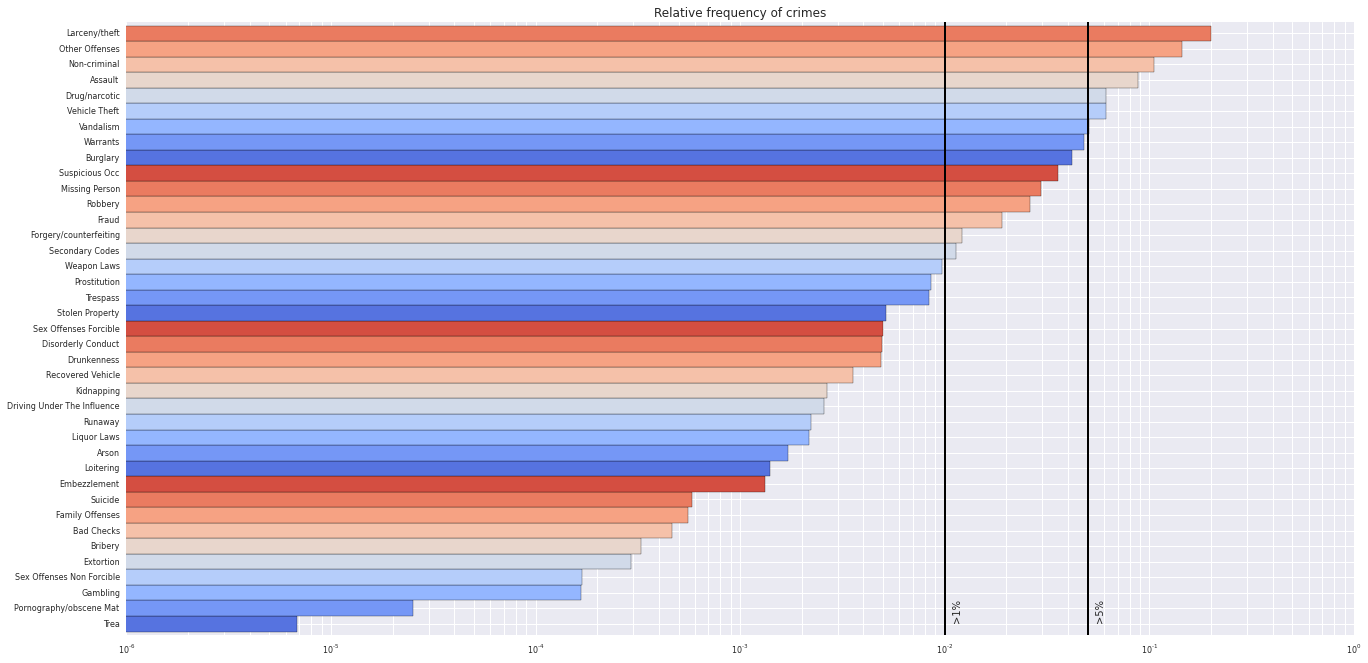

In [172]:
# what are the most recored crimes?

column='Category'
by_col = train.groupby(column)
cf = by_col.size()
cf.index = cf.index.map(string.capwords)
cf.sort(ascending=True, inplace=True)
Ntot=sum(cf)
cf/=Ntot

figure(figsize=(22,11),dpi=500)
cf.plot(kind='barh',
        title='Relative frequency of crimes',
        fontsize=8,
        stacked=False,
        width=1,
        color=sns.color_palette('coolwarm', 10)
        )
#grid()
xscale('log',nonposx='clip')
plt.axvline(x=0.05, ymin=0.0, ymax = 1, linewidth=2, color='k')
plt.text(0.055,1,'>5%',rotation=90)
plt.axvline(x=0.01, ymin=0.0, ymax = 1, linewidth=2, color='k')
plt.text(0.011,1,'>1%',rotation=90)

# contribution from the top 6 crimes:
topsum=0
for i in ("LARCENY/THEFT","ASSAULT","OTHER OFFENSES","DRUG/NARCOTIC","VEHICLE THEFT","NON-CRIMINAL"):
    tt=train[train.Category==i]
    topsum=topsum+len(tt)
print "The top 6 crimes make up "+str(100*topsum/float(Ntot))+"% of all crimes."

/Library/Python/2.7/site-packages/ipykernel/__main__.py:8: FutureWarning: sort is deprecated, use sort_values(inplace=True) for for INPLACE sorting


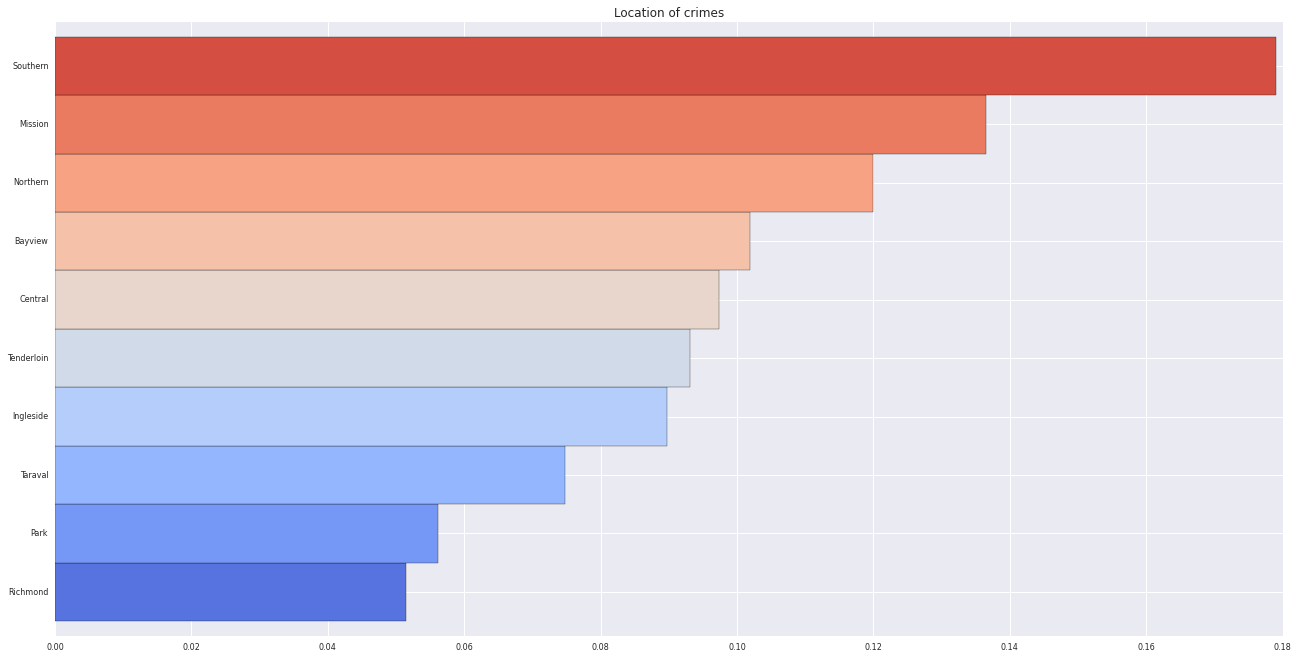

In [159]:
# where are the most crimes reported?
# 18% of crimes in Southern, 5% of crimes in Richmond

column='PdDistrict'
by_col = train.groupby(column)
cf = by_col.size()
cf.index = cf.index.map(string.capwords)
cf.sort(ascending=True, inplace=True)
Ntot=sum(cf)
cf/=Ntot

cf.plot(kind='barh',
        title='Location of crimes',
        fontsize=8,
        figsize=(22,11),
        stacked=False,
        width=1,
        color=sns.color_palette('coolwarm', Ndist)
        )
#xscale('log',nonposx='clip')
#grid()

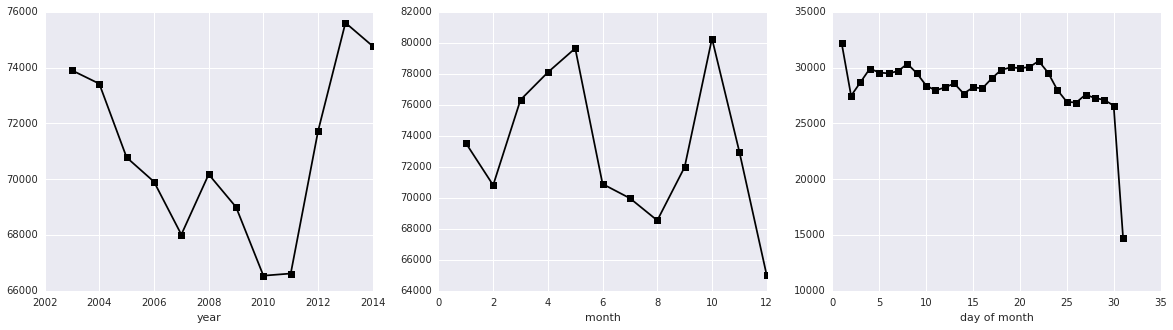

In [184]:
# number of crimes by year
# skip 2015 because lack of data

column='year'
by_col = train.groupby(column)
cf = by_col.size()
figure(figsize=(20,5))
subplot(1,3,1)
plot(cf.index[:Nyears-1],cf[:Nyears-1], 'ks-')
xlabel('year')

# number of crimes by month
# most crimes in May and October; December more safe?

column='month'
by_col = train.groupby(column)
cf = by_col.size()
subplot(1,3,2)
plot(cf.index,cf, 'ks-')
xlabel('month')

column='day'
by_col = train.groupby(column)
cf = by_col.size()
subplot(1,3,3)
plot(cf.index,cf, 'ks-')
xlabel('day of month')

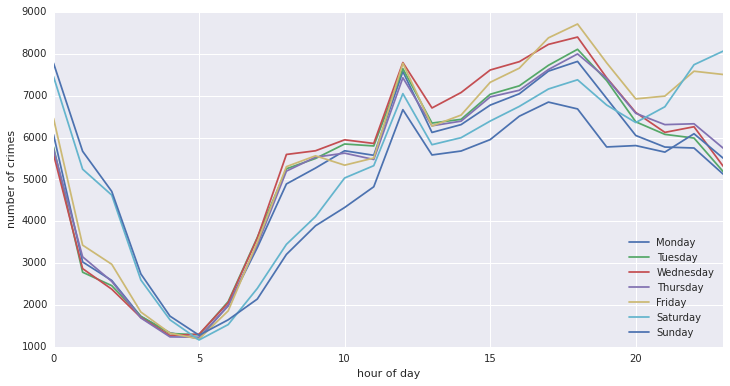

In [151]:
# plot the number of crimes vs time of day
# at the weekend more crimes in late night

figure(figsize=(12,6))
train['event']=1
for i in range(0,7):
    tt=train[train.DOW==i]
    hourly_events = tt[['hour','event']].groupby(['hour']).count().reset_index()
    plot(hourly_events.hour,hourly_events.event,label=wod[i])
    
legend(loc=4)
xlim(0,23);
ylabel("number of crimes")
xlabel("hour of day")

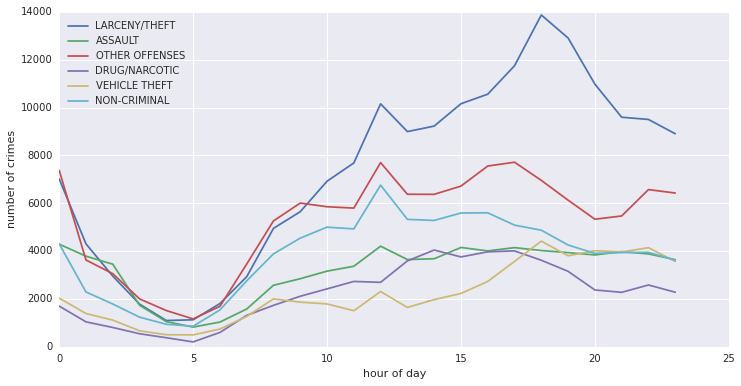

In [169]:
# hourly crimes for the top crimes individually

figure(figsize=(12,6))
for i in ("LARCENY/THEFT","ASSAULT","OTHER OFFENSES","DRUG/NARCOTIC","VEHICLE THEFT","NON-CRIMINAL"):
    train['event']=1
    tt=train[train.Category==i]
    hourly_events = tt[['hour','event']].groupby(['hour']).count().reset_index()
    plot(hourly_events.hour,hourly_events.event,label=i)
  

legend(loc=2)
#xlim(0,23);
ylabel("number of crimes")
xlabel("hour of day")

In [87]:
# define the classifier

est = RandomForestClassifier(n_estimators = 100)

#define the columns to be used for training
X=['DOW','distnum','day', 'month', 'year', 'hour', 'X', 'Y']
target='catnum'

# train the ML-algo using columns X and cross-validate
crossval(est, train, X, target)


log-loss: 20.5278314061
elapsed time: 235.284054041


In [88]:
# feature importances

importances = est.feature_importances_
indices = np.argsort(importances)[::-1]
print("Feature ranking:")
for f in range(len(X)):
    print("%d. feature: %s (%f)" % (f + 1, X[indices[f]], importances[indices[f]]))

Feature ranking:
1. feature: Y (0.194043)
2. feature: X (0.191253)
3. feature: day (0.160762)
4. feature: hour (0.131427)
5. feature: month (0.122765)
6. feature: year (0.094748)
7. feature: DOW (0.088530)
8. feature: distnum (0.016474)


In [ ]:
# now train on the whole dataset

est.fit(train[X], train[target])

In [ ]:
# make prediction for test set

test['catnum'] = est.predict(test[X])

# make a submit file

test['Category'] = (test['catnum']).map(muntac)

def field_to_columns(data, field, new_columns):
    for i in range(len(new_columns)):
        data[new_columns[i]] = (data[field] == new_columns[i]).astype(int)
    return data

categories = pd.unique(train.Category.ravel())
test = field_to_columns(test, 'Category', categories)
submission_cols = (['Id','WARRANTS', 'OTHER OFFENSES', 'LARCENY/THEFT', 'VEHICLE THEFT','VANDALISM',
 'NON-CRIMINAL', 'ROBBERY', 'ASSAULT', 'WEAPON LAWS', 'BURGLARY',
 'SUSPICIOUS OCC', 'DRUNKENNESS', 'FORGERY/COUNTERFEITING', 'DRUG/NARCOTIC',
 'STOLEN PROPERTY', 'SECONDARY CODES', 'TRESPASS', 'MISSING PERSON', 'FRAUD',
 'KIDNAPPING', 'RUNAWAY', 'DRIVING UNDER THE INFLUENCE',
 'SEX OFFENSES FORCIBLE', 'PROSTITUTION', 'DISORDERLY CONDUCT', 'ARSON',
 'FAMILY OFFENSES', 'LIQUOR LAWS' ,'BRIBERY', 'EMBEZZLEMENT', 'SUICIDE',
 'LOITERING' ,'SEX OFFENSES NON FORCIBLE' ,'EXTORTION', 'GAMBLING',
 'BAD CHECKS', 'TREA', 'RECOVERED VEHICLE', 'PORNOGRAPHY/OBSCENE MAT'])

test[submission_cols].to_csv("submit.csv", index = False)